<a href="https://colab.research.google.com/github/maxstclair/DS4002/blob/main/Project_1/SCRIPTS/Seasonality_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/maxstclair/DS4002

Cloning into 'DS4002'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 518 (delta 13), reused 3 (delta 3), pack-reused 485 (from 2)
Receiving objects: 100% (518/518), 2.79 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [18]:
season_df = pd.read_csv('/content/DS4002/Project_1/DATA/final_restaurant_df.csv')
season_df.drop(['Unnamed: 0'], axis = 1, inplace=True)
season_df.head()

,Date,Rating,Message,Author Reviews,Restaurant,sentiment,DayOfWeek
0,2023-02-19,5.0,This place was better than the 3 Michelin-star...,82.0,Black Cow,0.9965,Sunday
1,2023-02-19,5.0,"I have to say, this place is a steakhouse like...",113.0,Black Cow,0.9674,Sunday
2,2023-02-26,5.0,Loved this place! They were completely booked ...,28.0,Black Cow,0.9937,Sunday
3,2023-05-03,4.0,"Food is excellent, best steak in a very long t...",24.0,Black Cow,0.7604,Wednesday
4,2023-08-03,5.0,The food here is incredible! The service was e...,23.0,Black Cow,0.9845,Thursday


### Create dummy variables for summer (Jun-Sep) and winter (Dec-Mar)



In [24]:
season_df['month'] = pd.to_datetime(season_df['Date']).dt.month
season_df['winter'] = season_df['month'].isin([12,1,2]).astype(int)
season_df['summer'] = season_df['month'].isin([6,7,8]).astype(int)
season_df.head(5)

,Date,Rating,Message,Author Reviews,Restaurant,sentiment,DayOfWeek,month,winter,summer
0,2023-02-19,5.0,This place was better than the 3 Michelin-star...,82.0,Black Cow,0.9965,Sunday,2.0,1,0
1,2023-02-19,5.0,"I have to say, this place is a steakhouse like...",113.0,Black Cow,0.9674,Sunday,2.0,1,0
2,2023-02-26,5.0,Loved this place! They were completely booked ...,28.0,Black Cow,0.9937,Sunday,2.0,1,0
3,2023-05-03,4.0,"Food is excellent, best steak in a very long t...",24.0,Black Cow,0.7604,Wednesday,5.0,0,0
4,2023-08-03,5.0,The food here is incredible! The service was e...,23.0,Black Cow,0.9845,Thursday,8.0,0,1


### Implement multiple fixed effects model

In [30]:
model = smf.mixedlm(
    formula="sentiment ~ summer",
    data=season_df,
    groups=season_df['Restaurant'],
    re_formula="~summer"
)
result = model.fit(method='bfgs')
result.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  sentiment 
No. Observations:    2566     Method:              REML      
No. Groups:          22       Scale:               0.1719    
Min. group size:     80       Log-Likelihood:      -1408.6755
Max. group size:     121      Converged:           Yes       
Mean group size:     116.6                                   
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.777    0.024 32.994 0.000  0.731  0.824
summer              0.013    0.021  0.635 0.526 -0.028  0.054
Group Var           0.010    0.009                           
Group x summer Cov -0.004    0.007                           
summer Var          0.002    0.007                           
=============================================================

"""

In [32]:
re_df = result.random_effects
re_df

{'Asado': Group    -0.138892
 summer    0.053627
 dtype: float64,
 'Bang': Group    -0.013133
 summer    0.003226
 dtype: float64,
 'Belle': Group    -0.001083
 summer   -0.002653
 dtype: float64,
 'Black Cow': Group     0.027907
 summer   -0.005197
 dtype: float64,
 'Brazos': Group    -0.013721
 summer    0.006701
 dtype: float64,
 'C&O': Group     0.084654
 summer   -0.034370
 dtype: float64,
 'Duners': Group    -0.004267
 summer    0.005020
 dtype: float64,
 'Guad': Group    -0.255947
 summer    0.105454
 dtype: float64,
 'Lampo': Group     0.027859
 summer   -0.017462
 dtype: float64,
 'Mas Tapas': Group     0.079588
 summer   -0.037710
 dtype: float64,
 'Monsoon': Group     0.019563
 summer   -0.011821
 dtype: float64,
 'Oakhart': Group     0.036181
 summer   -0.007637
 dtype: float64,
 'Orzo': Group     0.082511
 summer   -0.030777
 dtype: float64,
 'Smyrna': Group     0.090378
 summer   -0.031337
 dtype: float64,
 'Tavola': Group     0.072647
 summer   -0.023121
 dtype: float64,

### Predict confidence intervals and statistical significance for restuarant-level total effects

Function returns a dataframe with each restaurant's aggregate slope for seasonal effects (total effect = beta_1 + b_{season, restaurant}) and gives an approximate confidence interval
Parameters


*   result: the fitted statsmodels MixedLMResults object
*   alpha: significance level for confidence interval estimates, default = 0.05



Note: This is a frequentist approximation rather than a direct parameter estimate. It assumes fixed probabilities and ignores covariance between overall seasonal effect and fixed-effects at the restuarant level.

In [48]:
def get_restaurant_slope_intervals(result, alpha=0.05):
    # beta1: overall fixed effect
    beta_1 = result.params["summer"]
    var_beta_1 = result.cov_params().loc["summer", "summer"]

    # variance of restuarant-level slope on summer dummy
    var_b1 = result.cov_re.loc["summer", "summer"]

    # standard error approximation ignoring covariance term
    se_approx = np.sqrt(var_beta_1 + var_b1)

    # accepts alpha values of 0.05, 0.01, and 0.1 to approximate z statistic
    z = 1.96 if alpha == 0.05 else 2.575 if alpha == 0.01 else 1.645 if alpha == 0.10 else 1.96

    rows = []
    for group_id, re_dict in result.random_effects.items():
        # random slope for "season" in that restaurant
        b1_r = re_dict.get("summer")
        slope_est = beta_1 + b1_r

        # compute 95% confidence interval using approx z statistic
        lower = slope_est - z * se_approx
        upper = slope_est + z * se_approx

        # significant if upper and lower estimates have same sign
        significant = (lower*upper)>0

        rows.append({
            "restaurant_id": group_id,
            "slope_estimate": slope_est,
            "ci_lower": lower,
            "ci_upper": upper,
            "significant at " + str(alpha):significant
        })

    return pd.DataFrame(rows)

get_restaurant_slope_intervals(result, alpha=0.05)

,restaurant_id,slope_estimate,ci_lower,ci_upper,significant at 0.05
0,Asado,0.066935,-0.028340,0.162211,False
1,Bang,0.016534,-0.078741,0.111809,False
2,Belle,0.010655,-0.084620,0.105930,False
3,Black Cow,0.008111,-0.087164,0.103386,False
4,Brazos,0.020009,-0.075266,0.115285,False
5,C&O,-0.021062,-0.116338,0.074213,False
6,Duners,0.018328,-0.076948,0.113603,False
7,Guad,0.118762,0.023487,0.214038,True
8,Lampo,-0.004154,-0.099430,0.091121,False
9,Mas Tapas,-0.024402,-0.119677,0.070874,False


In [49]:
get_restaurant_slope_intervals(result, alpha=0.1)

,restaurant_id,slope_estimate,ci_lower,ci_upper,significant at 0.1
0,Asado,0.066935,-0.013028,0.146899,False
1,Bang,0.016534,-0.063429,0.096497,False
2,Belle,0.010655,-0.069308,0.090618,False
3,Black Cow,0.008111,-0.071852,0.088074,False
4,Brazos,0.020009,-0.059954,0.099973,False
5,C&O,-0.021062,-0.101025,0.058901,False
6,Duners,0.018328,-0.061635,0.098291,False
7,Guad,0.118762,0.038799,0.198726,True
8,Lampo,-0.004154,-0.084117,0.075809,False
9,Mas Tapas,-0.024402,-0.104365,0.055562,False


Result: at 5% signficance level, Guad is estimated to be the only restaurant with signficant impact of seasonality, with a positive coefficient implying a lift in review sentiment during the summer months. No restaurant is significant at the 1% level, and the Ridley also shows a significant effect at the 10% level. It's interesting to see that both of these restaurants are lower-rated relative to the group, whereas most restaurants we tested had overwhelmingly positive reveiws which may be a reason that seasonal variation was not detected.

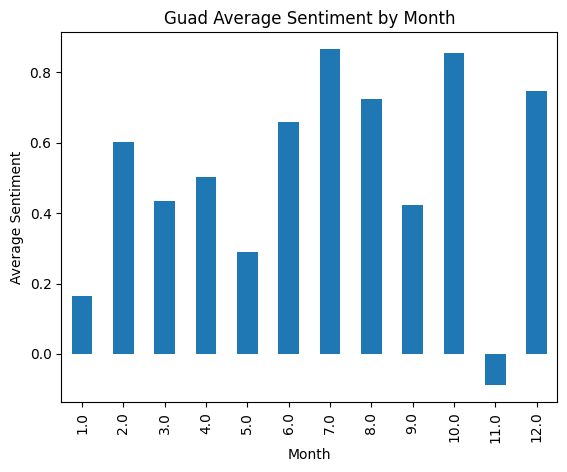

In [57]:
guad = season_df[season_df['Restaurant']=='Guad']
guad_monthly_average = guad.groupby('month')['sentiment'].mean()
guad_monthly_average.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.title('Guad Average Sentiment by Month')
plt.show()